<img src="./img/uomlogo.png" align="left"/><br><br>
# PHYS20762 - Project - Measuring Drop Spreading Law

Draga Pihler-Puzovic<br>
University of Manchester  
January 2021

Updated by j01124rd

February 2024

We first initialise our Python interpreter

In [1]:
# Initialisation
import string
from math import *
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.optimize import fsolve

# tweeking the figure size
plt.rcParams.update({'font.size': 14})
plt.style.use('default')
plt.rcParams["figure.figsize"] = (5,5)

![](./img/bee.png)
## Experimental Data

This is data that you are working with. It consists of a sequence of circle radii ($R$, measured in micrometers), obtained from image processing in three different experimental runs. The corresponding time ($t$, measured in seconds) was obtained from the image timestamps measured from the beginning of the experiment.     

In [2]:
# Radius data 
# experiment 1
radius_data1 = np.array([59.513027, 66.368389, 69.506166, 71.700852, 74.735925, 76.007795, 76.695256, 78.039551, 79.598386, 80.075493, 80.079624, 81.495363, 82.598934, 83.172805, 84.919440, 85.155809, 85.718415, 85.920147, 86.000243, 87.120934, 87.507943, 87.786892, 87.060409, 88.086562, 88.113767, 88.436448, 89.082172, 89.139957, 89.210538, 89.356928, 90.312937, 90.406557, 90.754907, 90.88941, 91.096467])
# experiment 2
radius_data2 = np.array([59.810888, 65.360919, 69.088934, 72.594631, 74.694093, 76.440186, 78.133942, 78.618537, 79.753566, 80.745559, 81.422723, 81.634563, 82.861597, 84.335873, 85.362055, 85.537714, 86.159399, 86.873675, 86.918131, 87.003533, 87.126402, 87.155440, 87.224911, 87.394479, 87.433936, 87.626938, 87.701465, 87.834029, 87.963874, 88.153147, 88.209880, 88.542036, 88.86527, 89.082038, 89.214132])
# experiment 3
radius_data3 = np.array([58.200029, 64.826353, 69.332991, 73.504694, 74.295033, 77.506575, 78.413291, 79.952682, 81.339708, 81.938359, 82.528196, 82.807452, 83.378999, 84.521468, 84.507216, 85.064265, 85.247146, 85.900079, 86.475709, 86.776052, 87.158810, 87.343755, 87.448085, 87.822712, 88.140434, 88.311032, 88.619312, 88.970210, 89.373613, 89.754486, 89.900430, 90.116608, 90.288358, 90.711677, 90.989783])
# time
time = np.array([0.500000, 1.000000, 1.500000, 2.000000, 2.500000, 3.000000, 3.500000, 4.000000, 4.500000, 5.000000, 5.500000, 6.000000, 6.500000, 7.000000, 7.500000, 8.000000, 8.500000, 9.000000, 9.500000, 10.000000, 10.500000, 11.000000, 11.500000, 12.000000, 12.500000, 13.000000, 13.500000, 14.000000, 14.500000, 15.000000, 15.500000, 16.000000, 16.500000, 17.000000, 17.500000])

Let's plot this data to see what it looks like:

### Plotting the raw data of radius against time
* Three data sets plotted on one graph
* We can observe similarities between each data point

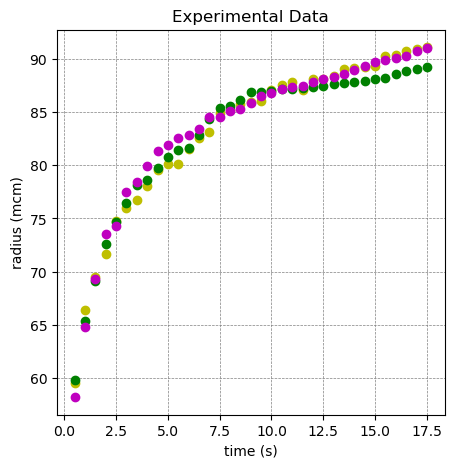

In [3]:

# plotting data from experimental runs 1-3:
plt.plot(time, radius_data1, "yo")
plt.plot(time, radius_data2, "go")
plt.plot(time, radius_data3, "mo")

# setting axis labels & figures 
plt.xlabel("time (s)")
plt.ylabel("radius (mcm)")
plt.title("Experimental Data")
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.show()

Don't forget to find the errors on $R$ estimated from the three experimental runs.

In [4]:
# Create the array of the three data sets
radius = np.array([radius_data1, radius_data2, radius_data3])
# Take a mean value based on three data sets
radius_mean = np.mean(radius, axis = 0)
# Take standard deviation on each data sets to determine the errors
radius_std = np.std(radius, axis = 0)

![](./img/bee.png)
## Extracting Quantities Using Experimental Data

* Plotting mean radius against the time to observe how droplet evolve during the spreading
* The standard error is included from standard deviation of 3 experiments

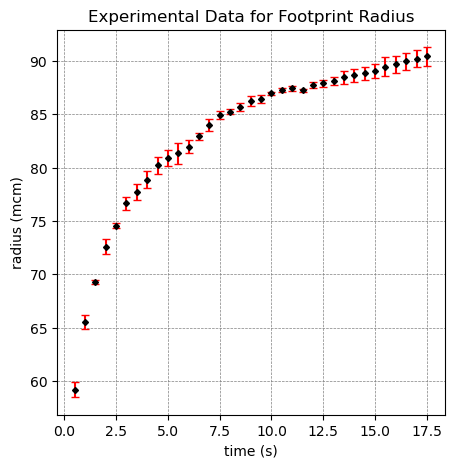

In [5]:
# Plot of the combined data with the calculated uncertainties
plt.errorbar(time, radius_mean, yerr=radius_std, fmt='kD', ecolor='red', capsize=3, markersize=3)
plt.xlabel("time (s)")
plt.ylabel("radius (mcm)")
plt.title("Experimental Data for Footprint Radius")
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.show()

In order to find the spreading law: a relationship between the speed of the contact line ($U$) and the contact angle ($\theta$), we need to first find the quantities themselves, ie express $U$ and $\theta$ using $R=R(t)$. 

To speed of the contact line can be calculated using $U = \frac{dR}{dt} \approx \frac{R(t+\delta t)-R(t)}{\delta t}$, where $R(t+\delta t)$ and $R(t)$ are two sequential values of the footprint radii measured with time intreval $\delta t$ apart.  

To find the contact angle, we make the spherical cap approximation that allows us to calculate the height of the drop ($H$) from its volume ($V=7.6$ pL) and its footprint radius ($R$) which are known from experiments via relationship $V=\frac{\pi}{6}H(3R^2+H^2)$. The contact angle can then be found from $R$ and $H$ using $\theta = \frac{\pi}{2} - \mathrm{atan}\frac{R^2-H^2}{2HR}$. 

There are three sets of experimental data, so for each one of them a relationship $U=U(\theta)$ should be found.

### Mean Speed and standard deviation

* Creating the function that find the contact speeds using two consecutive radii and time interval.
* Creating an array of three sets of speed data.
* Calculating mean an standard deviation from these three experiments.

In [6]:
def calculate_contact_line_speed(radii, delta_t):
    """
    This function determines contact line speed using 
    the difference of two consecutive footprint radii 
    that are divided by the time interval.
    
    Parameters:
    radii - measured radius in mcm (float)
    delta_t - time difference between two consecutive values in sec (float)
    
    Returns: 
    Contact line speeds
    """
    # List to store the calculated speeds
    speeds = []
    
    # Iterate over the radii list, except for the last element, 
    # to calculate the speed
    for i in range(len(radii) - 1):
        # Calculate the difference in radii
        delta_r = radii[i + 1] - radii[i]
        
        # Calculate the speed using the given formula
        speed = delta_r / delta_t
        
        # Append the calculated speed to the list
        speeds.append(speed)
    
    return speeds

# Define time interval using two consecutive time values
time_interval = time[1]-time[0]

# Contact speed line for each experiment
contact_speed_line_exp1 = calculate_contact_line_speed(radius_data1, time_interval)
contact_speed_line_exp2 = calculate_contact_line_speed(radius_data2, time_interval)
contact_speed_line_exp3 = calculate_contact_line_speed(radius_data3, time_interval)

# Define contact speed line using mean radius and time interval
contact_speed_line = calculate_contact_line_speed(radius_mean, time_interval)

def calculate_contact_line_speed_std(radii_std, delta_t):
    """
    This function determines contact line speed standard deviation
    by adding in quadrature two consecutive standard errors on the 
    previously found footprint radii.
    
    Parameters:
    radii_std - measured standard deviation of radius in mcm (float)
    delta_t - time difference between two consecutive values in sec (float)
    
    Returns:
    Standard deviation of contact line speeds.
    """
    # List to store the calculated speeds
    speeds_std = []
    
    for i in range(len(radii_std) - 1):
        # Calculate the added in quadrature sequential radii errors
        delta_r_std = np.sqrt(radii_std[i + 1]**2 + radii_std[i]**2)
        
        # Calculate the speed error using the given formula
        speed_std = delta_r_std / delta_t
        
        # Append the calculated speed to the list
        speeds_std.append(speed_std)
    
    return speeds_std

contact_speed_line_std = calculate_contact_line_speed_std(radius_std, time_interval)


### Plotting three sets of speed data 
* Similarly to radius we plotted obtained three data sets of speed against the time to observe how speed decreases over time

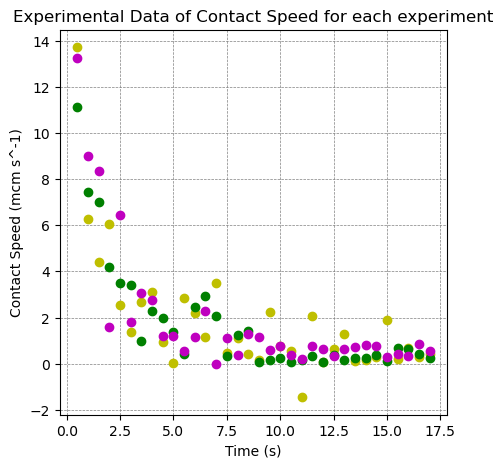

In [7]:
# Plotting data from experimental runs 1-3:
plt.plot(time[:-1], contact_speed_line_exp1, "yo")
plt.plot(time[:-1], contact_speed_line_exp2, "go")
plt.plot(time[:-1], contact_speed_line_exp3, "mo")

# Setting axis labels & figures 
plt.xlabel("Time (s)")
plt.ylabel("Contact Speed (mcm s^-1)")
plt.title("Experimental Data of Contact Speed for each experiment")
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.show()

### Heights 
* Solving spherical cap approximation for H 
$$V - \frac{\pi H (3R^2+H^2)}{6}=0$$
* We must first set it to zero
* We used data in SI units so that volume is converted from picoliters to metres cubed and radius is converted from micro meters to meters
* The following code calculates heights using mean radius

### Three separate data for height
* The second part of the code calculates heights for each data set separately

In [8]:
def spherical_cap_approximation(height, radius, volume):
    """
    Spherical cap approximation that is required to determine the heights.
    
    Parameters:
    height - maximum droplet height (float)
    radius - measured radius of the droplet (float)
    volume - volume of the droplet (float)
    
    Returns:
    Spherical cap approximation function
    """
    return volume - (np.pi * height * (3 * radius**2 + height**2) / 6)

# Conversion to SI units
volume = 7.6 * 10**(-15) # in units m^3
radius_mean_meters = radius_mean * 10**(-6) # in units m

def find_H_solutions(radius_data, volume):
    """
    Solving cubic equation to obtain heights solutions for each experimental set.
    
    Parameters:
    radius_data - iterate through data radius data
    volume - volume of the droplet
    
    Returns: 
    Heights
    """
    H_solutions = []  # Initialize an empty list to store solutions for H

    for R in radius_data:
        
        # Solve for H using fsolve, providing an initial guess for H
        H_solution = fsolve(spherical_cap_approximation, x0=1e-6, args=(R * 10**(-6), volume))
        
        # Append the solution to the list
        H_solutions.append(H_solution[0])

    return H_solutions

# Extract solutions for height from each radius data set in units of meters
H_solutions_data1_meters = find_H_solutions(radius_data1, volume)
H_solutions_data2_meters = find_H_solutions(radius_data2, volume)
H_solutions_data3_meters = find_H_solutions(radius_data3, volume)

# Combine all solutions into an array
heights_array = np.array([H_solutions_data1_meters, H_solutions_data2_meters, H_solutions_data3_meters])

# Convert solutions of H into mcm unit
heights_array_in_mcm = heights_array * 10**(6) # in units mcm

mean_heights = np.mean(heights_array_in_mcm, axis=0)

### Error propagation on heights
* We must propagate error on heights in order to find error on contact angle 
* This can be done by implicitly differentiate spherical cap approximation and rearrange for $\frac{\partial H}{\partial R}$
* The expression for this error propagation is given as
$$\Delta H = \left(\frac{2RH}{R^2+H^2}\right)\Delta R$$

In [9]:
def error_height(radius, height, delta_radius):
    """
    This function propagate an error on heights.
    
    Parameters:
    height - maximum droplet height (float)
    radius - measured radius of the droplet (float)
    delta_radius - standard deviation on the footprint radius (float) in mcm
    
    Returns:
    Standard error on mean heights.
    """
    return ((2 * radius * height) / (radius**2 + height**2)) * delta_radius

height_uncertainty = error_height(radius_mean, mean_heights, radius_std)

### Contact Angles using three separate data of heights and radii
* This part of the code calculates contact angle for each of heights and radius data
* From obtained height values we can calculate contact angle using
$$\theta = \frac{\pi}{2}-\arctan{\frac{R^2-H^2}{2RH}}$$
* We then therefore, combine contact angles into an array
* Finally, calculate mean value of all three data sets

In [10]:
def contact_angle(height, radius):
    """
    This function determine the contact angle, 
    from previously determined heights and based on 
    the experimental data of footprint radii.
    
    Parameters:
    height - maximum droplet height (float)
    radius - measured radius of the droplet (float)
    
    Returns:
    Contact Angle
    """
    return (np.pi / 2) - np.arctan((radius**2 - height**2) / (2 * radius * height))

contact_angle_1 = contact_angle(heights_array_in_mcm[0], radius_data1)
contact_angle_2 = contact_angle(heights_array_in_mcm[1], radius_data2)
contact_angle_3 = contact_angle(heights_array_in_mcm[2], radius_data3)

# Create the array of the three data sets
contact_angle_array = np.array([contact_angle_1, 
                            contact_angle_2, contact_angle_3])
# Take a mean value based on three data sets
contact_angle_mean = np.mean(contact_angle_array, axis = 0)

In [11]:
def error_contact_angle(radius, height, delta_radius, delta_height):
    """
    This function propagates an error on contact angle
    using mean values of radius and height and also errors
    associated with them.
    
    Parameters:
    height - maximum droplet height (float)
    radius - measured radius of the droplet (float)
    delta_radius - standard deviation on the footprint radius (float) in mcm
    delta_height - standard deviation on the height (float) in mcm
    """
    partial_wrt_radius = ((- 2 * height) / (radius**2 + height**2))
    partial_wrt_height = ((2 * radius) / (radius**2 + height**2))
    
    return np.sqrt(((partial_wrt_radius)**2 * delta_radius**2) + ((partial_wrt_height)**2 * delta_height**2))

angle_uncertainty = error_contact_angle(radius_mean, mean_heights, radius_std, height_uncertainty)

### Plotting raw data of contact speeds against contact angles
* This plot shows how each set of experiment differed and suggests expected shape of mean values of contact angle

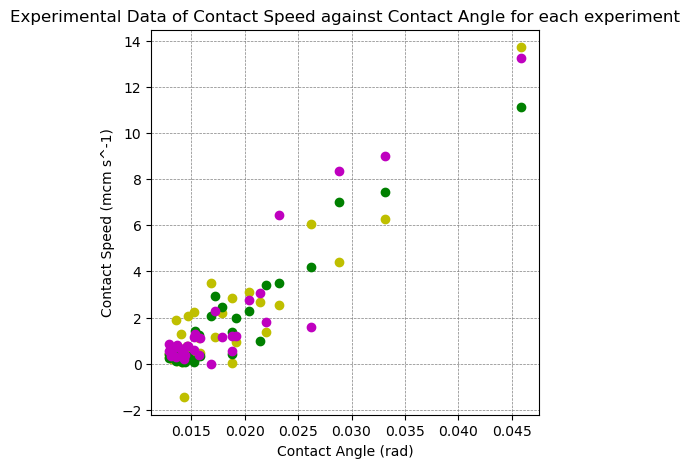

In [12]:
# Plotting data from experimental runs 1-3:
plt.plot(contact_angle_1[:-1], contact_speed_line_exp1, "yo")
plt.plot(contact_angle_1[:-1], contact_speed_line_exp2, "go")
plt.plot(contact_angle_1[:-1], contact_speed_line_exp3, "mo")

# Setting axis labels & figures 
plt.xlabel("Contact Angle (rad)")
plt.ylabel("Contact Speed (mcm s^-1)")
plt.title("Experimental Data of Contact Speed against Contact Angle for each experiment")
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.show()

### Plotting mean contact speed with error against time and against the contact angle with associated error.
The data $U=U(\theta)$ obtained for each of the three experimental runs is used to estimate the relationship between the mean contact line speed and the mean contact angle, and the corresponding errors on those. The result of this is plotted below. 

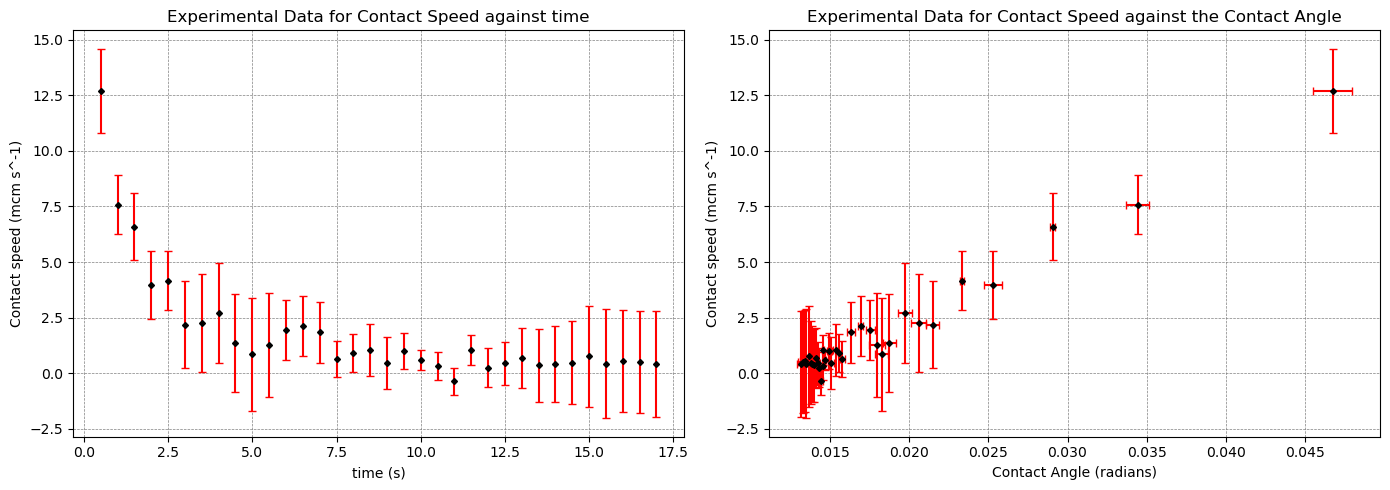

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))  # 1 row, 2 columns, and setting the figure size

# Plot on the first subplot
axs[0].errorbar(time[:-1], contact_speed_line, yerr=contact_speed_line_std, 
                fmt='kD', ecolor='red', capsize=3, markersize=3)
axs[0].set_xlabel("time (s)")
axs[0].set_ylabel("Contact speed (mcm s^-1)")
axs[0].set_title("Experimental Data for Contact Speed against time")
axs[0].grid(True, color='gray', linestyle='--', linewidth=0.5)

# Plot on the second subplot
axs[1].errorbar(contact_angle_mean[:-1], contact_speed_line, yerr=contact_speed_line_std, 
                xerr=angle_uncertainty[:-1], fmt='kD', ecolor='red', capsize=3, markersize=3)
axs[1].set_xlabel("Contact Angle (radians)")
axs[1].set_ylabel("Contact speed (mcm s^-1)")
axs[1].set_title("Experimental Data for Contact Speed against the Contact Angle")
axs[1].grid(True, color='gray', linestyle='--', linewidth=0.5)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

![](./img/bee.png)
## Fitting Spreading Laws

We will now attemp to fit the Cox-Voinov law ($U = U_0( \theta^3 –  \theta_0^3)$) and the de Gennes law ($U = U_0( \theta^2 –  \theta_0^2)$) to the mean data $U=U(\theta)$ ploted above, where $U_0$ is termed the characteristic speed of the contact line, and $\theta_0$ is the equilibrium contact angle (when $\theta=\theta_0$, $U=0$). To avoid using nonlinear least square method, we will fit a straight line to the data $U=U(\theta^2)$ and $U=U(\theta^3)$. This will produce the values for the characteristic speed and the error on it $U_0^{fit} \pm \delta U_0^{fit}$, but it will not give the values of the equilibrium contact angle $\theta_0^{fit}$. Instead, $[U_0\theta^n]^{fit}$ with $n=2$ or $n=3$ will be found, from which $\theta_0$ can be comupted. The corresponding error $\delta\theta^{fit}$ should be found by propagating the errors from  $[U_0\theta^n]^{fit}$ and $U_0^{fit}$.

### Fitting de Gennes Law
* Defining de Gennes Law
$$U(\theta)=U_0 (\theta^2-\theta_0^2)$$
* Squaring contact angles
* Usign polyfit to obtain model function  
* Gradient, and intercept are $U_0$ and $-U_0\theta_0^2$ respectively
* Creating linspace of theta values for the plotting
* Determining errors on coefficient using covariance matrix
* Finding value for $\theta_0$ 
$$c = -U_0\theta_0^2 \to \theta_0 = \sqrt{\frac{c}{-U_0}}$$

In [14]:
def de_Gennes_law(contact_angle, contact_speed_0, contact_angle_0):
    """
    Compute the contact line speed U based on the de Gennes law.

    Parameters:
    - contact_angle: Contact angle (in radians).
    - contact_speed_0: Characteristic speed of the contact line.
    - contact_angle_0: Equilibrium contact angle (in radians).

    Returns:
    - contact_speed: Contact line speed.
    """
    return contact_speed_0 * (contact_angle**2 - contact_angle_0**2)

# Creating the linspace of contact angle values 
theta_fit = np.linspace(contact_angle_mean[:-1].min(), contact_angle_mean[:-1].max(), 34)

# Determining best fit line 
coeffs, covr = np.polyfit(contact_angle_mean[:-1]**2, contact_speed_line, 1, cov=True)

# Computing the errors on coefficients
errors = np.sqrt(np.diag(covr))

# Determining value of theta_0
theta_0_2 = np.sqrt(coeffs[1] / -coeffs[0])

# Setting modelled function for plotting
model_de_gennes_fit = de_Gennes_law(theta_fit, coeffs[0], theta_0_2)

### Error on $\theta_0$ using de Gennes Law
* Propagating an errors on $\theta_0$ using formula
$$\Delta \theta_0 = \sqrt{\left(\frac{1}{2U_0\theta_0}\right)^2 \cdot (\Delta c)^2+\left(\frac{c}{2U_0^2 \theta_0}\right)^2 \cdot (\Delta U_0)^2}$$

In [15]:
def delta_theta_0(theta_0, U_0, intercept, delta_U_0, delta_intercept):
    """
    This function determines the uncertainty on the theta_0 
    when fit is modelled using the de Gennes Law.
    It propagates errors from an intercept and gradient.
    """
    partial_wrt_intercept = 1 / (2 * U_0 * theta_0)
    
    partial_wrt_U_0 = intercept / (2 * U_0**2 * theta_0)
    
    return np.sqrt(partial_wrt_intercept**2 * delta_intercept**2 + partial_wrt_U_0**2 * delta_U_0**2)

error_theta_0 = delta_theta_0(theta_0_2, coeffs[0], coeffs[1], errors[0], errors[1])

### Printing values associated to de Gennes law
* We print raw values of found coefficient
* We then specify that gradient is representing $U_0$ and intercept $-U_0\theta_0^2$
* Print found value of equilibrium angle, $\theta_0$, with associated error.

In [16]:
# Printed values
print('The de Gennes Law')
print('The computed coeffcients are ', coeffs[0],'and', coeffs[1])
print('The value of gradient that represents U_0 is {:4.2g} +/- {:4.2g}'.format(coeffs[0], errors[0]), 'mcm')
print('The value of intercept that represents -U_0*theta_0^2 is {:4.2g} +/- {:4.2g}'.format(coeffs[1], errors[1]), 'mcm rad^2')
print('The value of theta_0 is {:4.2g} +/- {:4.2g}'.format(theta_0_2, error_theta_0), 'rad')

The de Gennes Law
The computed coeffcients are  6571.446945962134 and -0.6088339558436152
The value of gradient that represents U_0 is 6.6e+03 +/- 2.6e+02 mcm
The value of intercept that represents -U_0*theta_0^2 is -0.61 +/- 0.14 mcm rad^2
The value of theta_0 is 0.0096 +/- 0.0011 rad


### Fitting Cox-Voinov Law
* Defining Cox-Voinov Law
$$U(\theta)=U_0 (\theta^3-\theta_0^3)$$
* Cubing contact angles
* Usign polyfit to obtaine model function  
* Gradient, and intercept are $U_0$ and $U_0\theta_0^3$ respectively
* Creating linspace of theta values for the plotting
* Determining errors on coefficient using covariance matrix
* Printing coefficients with associated errors
* Finding value for $\theta_0$ 
$$c = -U_0\theta_0^3 \to \theta_0 = \left({\frac{c}{-U_0}}\right)^{1/3}$$

In [17]:
def Cox_Voinov_law(contact_angle, contact_speed_0, contact_angle_0):
    """
    Compute the contact line speed U based on the Cox-Voinov Law.

    Parameters:
    - contact_angle: Contact angle (in radians).
    - contact_speed_0: Characteristic speed of the contact line.
    - contact_angle_0: Equilibrium contact angle (in radians).

    Returns:
    - contact_speed: Contact line speed.
    """
    return contact_speed_0 * (contact_angle**3 - contact_angle_0**3)

# Determining best fit line 
coeffs2, covr2 = np.polyfit(contact_angle_mean[:-1]**3, contact_speed_line,
                            1, cov=True)

# Computing the errors on coefficients
errors2 = np.sqrt(np.diag(covr2))

# Determining value of theta_0
theta_0_3 = -(coeffs2[1] / coeffs2[0])**(1 / 3)

# Setting modelled function for plotting
cox_voinov_fit = Cox_Voinov_law(theta_fit, coeffs2[0], theta_0_3)

### Error on $\theta_0$ using the Cox-Voinov Law
* Propagating an errors on $\theta_0$ using formula
$$\Delta \theta_0 = \sqrt{\left(-\frac{\theta_0}{3c}\right)^2 \cdot (\Delta c)^2+\left(\frac{\theta_0}{3U_0}\right)^2 \cdot (\Delta U_0)^2}$$

In [18]:
def delta_theta_0_cox(theta_0, U_0, intercept, delta_U_0, delta_intercept):
    """
    This function determines the uncertainty on the theta_0 
    when fit is modelled using Cox-Voinov law.
    It propagates errors from an intercept and gradient.
    """
    partial_wrt_intercept = (1 / 3) * (theta_0 / intercept)
    
    partial_wrt_U_0 = (1 / 3) * (theta_0 / U_0)
    
    return np.sqrt(partial_wrt_intercept**2 * delta_intercept**2 + partial_wrt_U_0**2 * delta_U_0**2)

error_theta_0_cox = delta_theta_0_cox(theta_0_2, coeffs2[0], coeffs2[1], errors2[0], errors2[1])

### Printing values associated to the Cox-Voinov law
* We print raw values of found coefficient
* We then specify that gradient is representing $U_0$ and intercept $-U_0\theta_0^3$
* Print found value of equilibrium angle, $\theta_0$, with associated error.

In [19]:
# Print values
print('The Cox-Voinov Law')
print('The computed coeffcients are ', coeffs2[0],'and', coeffs2[1])
print('The value of gradient is {:4.2g} +/- {:4.2g}'.format(coeffs2[0], errors2[0]), 'mcm')
print('The value of intercept is {:4.2g} +/- {:4.2g}'.format(coeffs2[1], errors2[1]), 'mcm radian^3')
print('The value of theta zero is {:4.2g} +/- {:4.2e}'.format(theta_0_3, error_theta_0_cox), 'radians')

The Cox-Voinov Law
The computed coeffcients are  134471.34151974536 and 0.5925696314630433
The value of gradient is 1.3e+05 +/- 8.7e+03 mcm
The value of intercept is 0.59 +/- 0.17 mcm radian^3
The value of theta zero is -0.016 +/- 9.67e-04 radians


### Plotting both fits: the Cox-Voinov Law and the de Gennes Law

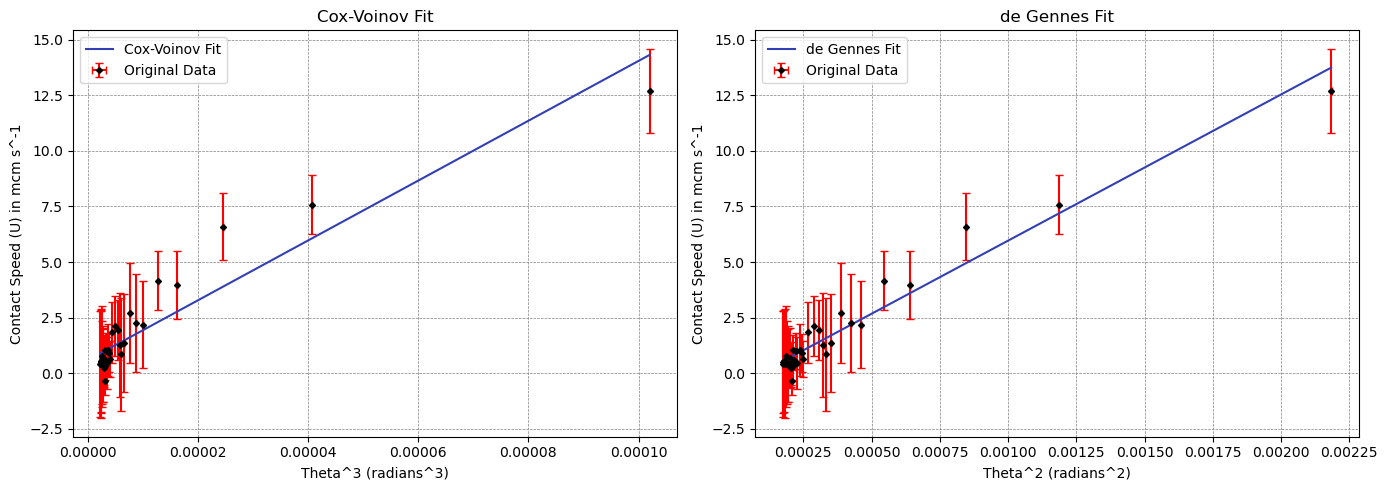

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))  # 1 row, 2 columns, and setting the figure size

# Plot for Cox-Voinov Fit
axs[0].errorbar(contact_angle_mean[:-1]**3, contact_speed_line, yerr=contact_speed_line_std, xerr=angle_uncertainty[:-1]**3, 
             fmt='kD', ecolor='red', capsize=3, markersize=3, label='Original Data')
axs[0].plot(theta_fit**3, cox_voinov_fit, color=(0.20, 0.25, 0.7, 1), label='Cox-Voinov Fit')
axs[0].set_xlabel('Theta^3 (radians^3)')
axs[0].set_ylabel('Contact Speed (U) in mcm s^-1')
axs[0].set_title('Cox-Voinov Fit')
axs[0].grid(True, color='gray', linestyle='--', linewidth=0.5)
axs[0].legend()

# Plot for de Gennes Fit
axs[1].errorbar(contact_angle_mean[:-1]**2, contact_speed_line, yerr=contact_speed_line_std, 
             xerr=angle_uncertainty[:-1]**2, fmt='kD', ecolor='red', capsize=3, markersize=3, label='Original Data')
axs[1].plot(theta_fit**2, model_de_gennes_fit, color=(0.20, 0.25, 0.7, 1), label='de Gennes Fit')
axs[1].set_xlabel('Theta^2 (radians^2)')
axs[1].set_ylabel('Contact Speed (U) in mcm s^-1')
axs[1].set_title('de Gennes Fit')
axs[1].grid(True, color='gray', linestyle='--', linewidth=0.5)
axs[1].legend()

plt.tight_layout()
plt.show()

![](./img/bee.png)
## Chi-squared Test
* We first find $\sigma^{fit}$ using residuals method
$$\sigma^{fit}=\sqrt{\frac{1}{N^{dof}}\sum^N_{j=1}\left(\frac{\bar{y}_j-y_j^{fit}}{\sigma_{y_j}}\right)^2}$$
* Then we calculate $\chi^2$ for each model function using 
$$\chi^2=\sum^N_{j=1}\left(\frac{\bar{y}_j-y_j^{fit}}{\sigma_{y_j}}\right)^2$$
*Finally, we can establish goodness of fit using reduced chi squared $\chi^2_{red}$
$$\chi^2_{red}=\frac{\chi^2}{N^{dof}}=\frac{\chi^2}{N-N^{params}}$$

In [21]:
def sigma_fit(number_of_degrees, contact_speed_line, contact_speed_line_std,
              model_de_gennes_fit, cox_voinov_fit):
    sigma_U_fit = np.sqrt((1 / number_of_degrees) *
                          np.sum(np.power((contact_speed_line - model_de_gennes_fit) /
                                          contact_speed_line_std, 2)))
    sigma_U_fit2 = np.sqrt((1 / number_of_degrees) *
                           np.sum(np.power((contact_speed_line - cox_voinov_fit) /
                                           contact_speed_line_std, 2)))
    return sigma_U_fit, sigma_U_fit2

number_of_degrees = len(contact_speed_line) - 2

sigma_U_fit, sigma_U_fit2 = sigma_fit(number_of_degrees, contact_speed_line, contact_speed_line_std,
                                      model_de_gennes_fit, cox_voinov_fit)

print('The expected error on data from the assumed de Gennes fit is {:1.3g}'.format(sigma_U_fit))
print('The expected error on data from the assumed Cox-Voinov fit is {:1.3g}'.format(sigma_U_fit2))

The expected error on data from the assumed de Gennes fit is 6
The expected error on data from the assumed Cox-Voinov fit is 5.25


### Residuals plots
* Residuals plotted in two separate regions due to higher concentration of data points for the similar values of contact angles
* One covering most of the clusterred data points and other region of data spread further apart

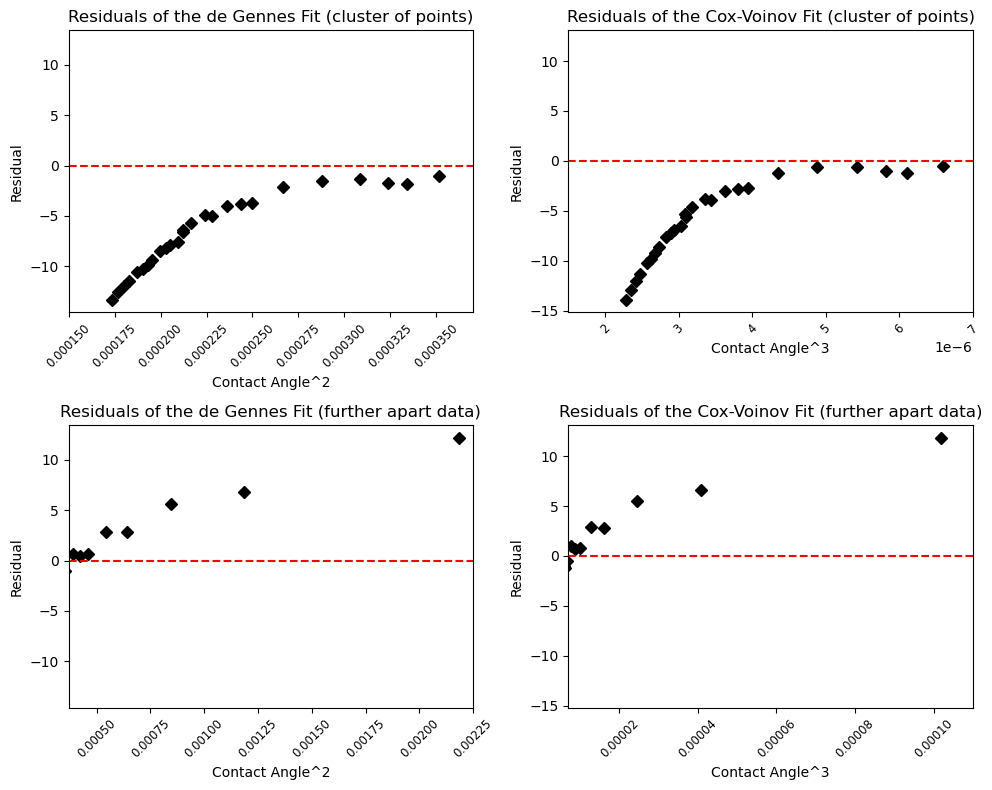

In [22]:
residuals_gennes = contact_speed_line - model_de_gennes_fit
residuals_cox = contact_speed_line - cox_voinov_fit

fig = plt.figure(figsize=(10, 8))

# Plot de Gennes law residuals shorter range
plt.subplot(2, 2, 1)
plt.plot(contact_angle_mean[:-1]**2, residuals_gennes, 'kD')
plt.axhline(0, color='red', linestyle='--')  # Add a horizontal line at 0 for reference
plt.tick_params(axis='x', labelrotation=45, labelsize='small')
plt.xlim([1.5E-4, 3.7E-4])
plt.xlabel('Contact Angle^2')
plt.ylabel('Residual')
plt.title('Residuals of the de Gennes Fit (cluster of points)')

# Plot Cox-Voinov Law residuals shorter range
plt.subplot(2, 2, 2)
plt.plot(contact_angle_mean[:-1]**3, residuals_cox, 'kD')
plt.axhline(0, color='red', linestyle='--')  # Add a horizontal line at 0 for reference
plt.tick_params(axis='x', labelrotation=45, labelsize='small')
plt.xlim([0.0000015, 0.000007])
plt.xlabel('Contact Angle^3')
plt.ylabel('Residual')
plt.title('Residuals of the Cox-Voinov Fit (cluster of points)')

# Plot de Gennes law residuals shorter range other part
plt.subplot(2, 2, 3)
plt.plot(contact_angle_mean[:-1]**2, residuals_gennes, 'kD')
plt.axhline(0, color='red', linestyle='--')  # Add a horizontal line at 0 for reference
plt.tick_params(axis='x', labelrotation=45, labelsize='small')
plt.xlim([3.7E-4, 0.00225])
plt.xlabel('Contact Angle^2')
plt.ylabel('Residual')
plt.title('Residuals of the de Gennes Fit (further apart data)')

# Plot Cox-Voinov Law residuals shorter range other part
plt.subplot(2, 2, 4)
plt.plot(contact_angle_mean[:-1]**3, residuals_cox, 'kD')
plt.axhline(0, color='red', linestyle='--')  # Add a horizontal line at 0 for reference
plt.tick_params(axis='x', labelrotation=45, labelsize='small')
plt.xlim([0.000007, 0.00011])
plt.xlabel('Contact Angle^3')
plt.ylabel('Residual')
plt.title('Residuals of the Cox-Voinov Fit (further apart data)')

plt.tight_layout()
plt.show()

In [23]:
def cal_chi_sqr(contact_speed_line, contact_speed_line_std, fit):
    """
    Calculating the chi squared for the analysis.
    """
    return sum(((contact_speed_line - fit) / (contact_speed_line_std))**2)

def reduced_chi_sqr(chi_squared, degrees_of_freedom):
    """
    Calculating reduced chi squared 
    by dividing chi squared by degrees of freedom.
    The range of values that determines perfect 
    fit should be in between 0.5-1.5.
    If the reduced chi squared is much greater, 
    the errors may be underestimated, if it 
    is much less than the given range, error are 
    overestimated.
    """
    return chi_squared / degrees_of_freedom

chi_squared = cal_chi_sqr(contact_speed_line, contact_speed_line_std, model_de_gennes_fit)
chi_squared2 = cal_chi_sqr(contact_speed_line, contact_speed_line_std, cox_voinov_fit)

reduced_chi_squared = reduced_chi_sqr(chi_squared, number_of_degrees)
reduced_chi_squared2 = reduced_chi_sqr(chi_squared2, number_of_degrees)

![](./img/bee.png)
## Drop Spreading Law Is

The results of the chi-squared analysis, along with the coefficients obtained, suggest that the de Gennes law provides a better description of the spreading droplet's behavior. This conclusion is supported by the physical significance of a positive equilibrium constant ($0.0096 +/- 0.0011$ radians) derived from the de Gennes fit, which is consistent with the expected shape of a droplet. In contrast, the negative equilibrium constant resulting from the Cox-Voinov fit suggests a non-physical droplet shape, rendering the fit theoretically implausible.

Although the reduced chi-squared value is lower for the Cox-Voinov fit, indicating a seemingly better fit from a statistical standpoint, the negative value of the equilibrium angle ($-0.016 +/- 9.67E-04$ radians) undermines its validity. Therefore, reliance solely on the reduced chi-squared value for model selection would be misleading in this context.

Comparison of the residual plots for both fitting functions does not decisively favor one model over the other, as they exhibit similar patterns. However, the high values of the reduced chi-squared for both models indicate a generally poor fit. This could be attributed to either the inherent scatter in the data points or a potential underestimation of the uncertainties associated with the contact line speed measurements.

In assessing the suitability of the models, it is imperative to consider both the statistical metrics and the physical interpretability of the fit parameters.

### Summary of all obtained values for both fits including Chi-squared analysis

In [24]:
print('The de Gennes Law')
print('The computed coeffcients are ', coeffs[0],'and', coeffs[1])
print('The value of gradient that represents U_0 is {:4.2g} +/- {:4.2g}'.format(coeffs[0], errors[0]), 'mcm')
print('The value of intercept that represents -U_0*theta_0^2 is {:4.2g} +/- {:4.2g}'.format(coeffs[1], errors[1]), 'mcm rad^2')
print('The value of theta_0 is {:4.2g} +/- {:4.2g}'.format(theta_0_2, error_theta_0), 'rad')
print('--------------------------------------------')
print('The Cox-Voinov Law')
print('The computed coeffcients are ', coeffs2[0],'and', coeffs2[1])
print('The value of gradient is {:4.2g} +/- {:4.2g}'.format(coeffs2[0], errors2[0]), 'mcm')
print('The value of intercept is {:4.2g} +/- {:4.2g}'.format(coeffs2[1], errors2[1]), 'mcm radian^3')
print('The value of theta zero is {:4.2g} +/- {:4.2e}'.format(theta_0_3, error_theta_0_cox), 'radians')
print('--------------------------------------------')
print('Chi-squared Analysis:')
print('The chi^2 is {:1.3f}'.format(chi_squared), 'using de Gennes Law')
print('The chi^2 is {:1.3f}'.format(chi_squared2), 'using Cox-Voinov Law')
print('The reduced chi^2 is {:1.3f}'.format(reduced_chi_squared), 'using de Gennes Law')
print('The reduced chi^2 is {:1.3f}'.format(reduced_chi_squared2), 'using Cox-Voinov Law')

The de Gennes Law
The computed coeffcients are  6571.446945962134 and -0.6088339558436152
The value of gradient that represents U_0 is 6.6e+03 +/- 2.6e+02 mcm
The value of intercept that represents -U_0*theta_0^2 is -0.61 +/- 0.14 mcm rad^2
The value of theta_0 is 0.0096 +/- 0.0011 rad
--------------------------------------------
The Cox-Voinov Law
The computed coeffcients are  134471.34151974536 and 0.5925696314630433
The value of gradient is 1.3e+05 +/- 8.7e+03 mcm
The value of intercept is 0.59 +/- 0.17 mcm radian^3
The value of theta zero is -0.016 +/- 9.67e-04 radians
--------------------------------------------
Chi-squared Analysis:
The chi^2 is 1150.283 using de Gennes Law
The chi^2 is 881.162 using Cox-Voinov Law
The reduced chi^2 is 35.946 using de Gennes Law
The reduced chi^2 is 27.536 using Cox-Voinov Law
